### Setup

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
style.use('ggplot')

/usr/local/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load Dataset and Randomization

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


### Preprocess the Data

In [3]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    preprocessed_features = selected_features.copy()
    preprocessed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"] / 
                                                 california_housing_dataframe["population"])
    return preprocessed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    return output_targets

### Training set and Validation set

In [4]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training Examples Summary: ")
display.display(training_examples.describe())
print("Validation Examples Summary: ")
display.display(validation_examples.describe())
print("Training Targets Summary: ")
display.display(training_targets.describe())
print("Validation Targets Summary: ")
display.display(validation_targets.describe())

Training Examples Summary: 


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.6,2647.6,540.9,1430.8,502.8,3.9,2.0
std,2.1,2.0,12.6,2150.2,418.0,1096.3,381.3,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1471.0,299.0,793.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2142.5,435.0,1173.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3166.0,651.0,1730.0,608.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,16122.0,5189.0,15.0,55.2


Validation Examples Summary: 


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.6,2634.2,535.8,1426.7,497.4,3.9,2.0
std,2.1,2.0,12.6,2250.0,429.7,1263.1,392.0,1.9,1.2
min,32.5,-124.3,1.0,11.0,3.0,8.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1438.0,294.0,780.0,278.0,2.6,1.5
50%,34.3,-118.5,29.0,2100.5,430.0,1156.0,405.0,3.6,1.9
75%,37.7,-118.0,37.0,3108.2,642.2,1694.0,593.0,4.8,2.3
max,41.8,-114.5,52.0,32627.0,6445.0,35682.0,6082.0,15.0,52.0


Training Targets Summary: 


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation Targets Summary: 


,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


### Input Function

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Quantile based buckets

In [6]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    quantiles = feature_values.quantile(
        [(i+1.)/(num_buckets+1.) for i in range(num_buckets)])
    return [quantiles[q] for q in quantiles.keys()]
get_quantile_based_boundaries(california_housing_dataframe["households"], 7)

[207.0, 282.0, 343.0, 409.0, 488.0, 605.25, 813.0]

### Construct Feature Columns

In [7]:
def construct_feature_columns():
    bucketized_latitude = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("latitude"),
        boundaries=get_quantile_based_boundaries(training_examples["latitude"], 50))
    bucketized_longitude = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("longitude"),
        boundaries=get_quantile_based_boundaries(training_examples["longitude"], 50))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("housing_median_age"),
        boundaries=get_quantile_based_boundaries(training_examples["housing_median_age"], 10))
    bucketized_total_rooms = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("total_rooms"),
        boundaries=get_quantile_based_boundaries(training_examples["total_rooms"], 10))
    bucketized_total_bedrooms = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("total_bedrooms"),
        boundaries=get_quantile_based_boundaries(training_examples["total_bedrooms"], 10))
    bucketized_population = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("population"),
        boundaries=get_quantile_based_boundaries(training_examples["population"], 10))
    bucketized_households = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("households"),
        boundaries=get_quantile_based_boundaries(training_examples["households"], 10))
    bucketized_median_income = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("median_income"),
        boundaries=get_quantile_based_boundaries(training_examples["median_income"], 10))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("rooms_per_person"),
        boundaries=get_quantile_based_boundaries(training_examples["rooms_per_person"], 10))
    
    long_x_lat = tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)
    
    feature_columns = set([
        long_x_lat,
        bucketized_latitude,
        bucketized_longitude,
        bucketized_housing_median_age,
        bucketized_total_rooms,
        bucketized_total_bedrooms,
        bucketized_population,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person
    ])
    return feature_columns

### Calculate Model Size

In [8]:
def model_size(estimator):
    variables = estimator.get_variable_names()
    size = 0
    for variable in variables:
        if not any(x in variable
                   for x in ['global_step',
                             'centered_bias_weight',
                             'bias_weight',
                             'Ftrl']
                  ):
            size += np.count_nonzero(estimator.get_variable_value(variable))
    return size

### Train the Model

#### L1 Regularization and FTRL Optimizer

In [9]:
def train_linear_classifier_model(learning_rate,
                                  regularization_strength,
                                  steps,
                                  batch_size,
                                  feature_columns,
                                  training_examples,
                                  training_targets,
                                  validation_examples,
                                  validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    # Create linear_classifier object and configure it
    # FtrlOptimizer() works better with l1_regularization
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate,
                                          l1_regularization_strength=regularization_strength)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns = construct_feature_columns(),
        optimizer = my_optimizer
    )
    
    # Create input functions
    training_input_fn = lambda: my_input_fn(training_examples,
                                            training_targets["median_house_value_is_high"],
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                    training_targets["median_house_value_is_high"],
                                                    shuffle=False,
                                                    num_epochs=1)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                      validation_targets["median_house_value_is_high"],
                                                      shuffle=False,
                                                      num_epochs=1)
    
    # Train linear_classifier in a loop
    print("Training model...")
    print("  LogLoss (on training data & validation data): ")
    training_log_losses = []
    validation_log_losses = []
    for period in range(0, periods):
        linear_classifier.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        # Predictions
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
        
        # Compute LogLoss
        training_log_loss = metrics.log_loss(training_targets,
                                             training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets,
                                               validation_probabilities)
        print("    Period %02d : %0.2f\t%0.2f" % (period+1,
                                                  training_log_loss,
                                                  validation_log_loss))
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished.")
        
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training", color="magenta")
    plt.plot(validation_log_losses, label="validation", color="g")
    plt.legend()
    return linear_classifier

Training model...
  LogLoss (on training data & validation data): 
    Period 01 : 0.33	0.34
    Period 02 : 0.29	0.30
    Period 03 : 0.27	0.28
    Period 04 : 0.26	0.27
    Period 05 : 0.25	0.27
    Period 06 : 0.24	0.26
    Period 07 : 0.24	0.26
    Period 08 : 0.23	0.25
    Period 09 : 0.23	0.25
    Period 10 : 0.23	0.25
Model training finished.
Model size: 789


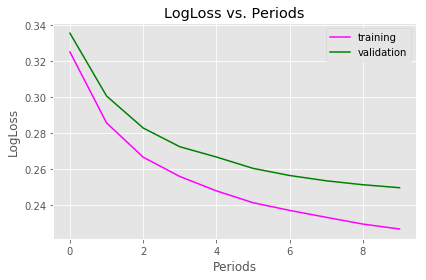

In [10]:
linear_classifier = train_linear_classifier_model(
    learning_rate = 0.1,
    regularization_strength = 0.0,
    steps = 300,
    batch_size = 100,
    feature_columns = construct_feature_columns(),
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)
print("Model size: %s" % model_size(linear_classifier))